In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import f_oneway, chi2_contingency
from typing import List # in python upper 3.9 can use built-in list directly
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score

In [215]:
train_test = {
    'test': 'test.csv',
    'train':'train.csv'
}
data_path = 'D:/Work/Data Science/Titanic/'
train_df = pd.read_csv(data_path + train_test['train'])
test_df = pd.read_csv(data_path + train_test['test'])
train_df.tail(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,NaN


In [216]:
df = train_df.copy()

In [ ]:
df.drop_duplicates()
df.describe()

In [112]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         3
dtype: int64

we have many nan values of Cabin. we have to drop it.

for Age and Embarked in analyst and initial-preprocessing, i will put mean/most-frequent values and after that maybe i will use Imputer for handling.

In [218]:
df[['Age']] = SimpleImputer(strategy='mean').fit_transform(df[['Age']])
df[['Embarked']] = SimpleImputer(strategy='most_frequent').fit_transform(df[['Embarked']])

# Preprocessing & Feature Engineering

In [219]:
df["title"] = (df["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip())
df["title"] = df["title"].where(
            df["title"].isin(["Mr", "Miss", "Mrs", "Master"]), "Other")

In [220]:
df["family_size"] = df["SibSp"] + df["Parch"] + 1  # +1 with him/her selves
df["IsAlone"] = (df["family_size"] == 1).astype(int)

In [222]:
df["Fare_per_person"] = df["Fare"] / df["family_size"].replace(0, np.nan)

In [221]:
AGE_GROUP_ORDER = ["Child", "Teenager", "Young Adult", "Adult", "Elderly"]
age_bins = [0, 12, 18, 30, 50, np.inf]
df["AgeGroup"] = pd.cut(df["Age"],bins=age_bins,labels=AGE_GROUP_ORDER,right=False)

In [223]:
FARE_CAT_ORDER = ["Low Class", "Basic Accommodation", "Middle Class", "Upper Mid Class", "First Class", "Luxury Suites"]
fare_bins = [-np.inf, 8, 20, 30, 50, 100, np.inf]
df["Fare_category"] = pd.cut(df["Fare"], bins=fare_bins, labels=FARE_CAT_ORDER)

In [224]:
df = df[["Pclass","Sex","Age","Fare","Embarked","title","family_size", "IsAlone", "AgeGroup", "Fare_category", "Fare_per_person", "Survived"]]
df.head(5)

,Pclass,Sex,Age,Fare,Embarked,title,family_size,IsAlone,AgeGroup,Fare_category,Fare_per_person,Survived
0,3,male,22.0,7.2500,S,Mr,2,0,Young Adult,Low Class,3.62500,0
1,1,female,38.0,71.2833,C,Mrs,2,0,Adult,First Class,35.64165,1
2,3,female,26.0,7.9250,S,Miss,1,1,Young Adult,Low Class,7.92500,1
3,1,female,35.0,53.1000,S,Mrs,2,0,Adult,First Class,26.55000,1
4,3,male,35.0,8.0500,S,Mr,1,1,Adult,Basic Accommodation,8.05000,0


# Data Analysis

C:\Users\Alireza\AppData\Local\Temp\ipykernel_12724\2824894634.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=survival_rate.index,
C:\Users\Alireza\AppData\Local\Temp\ipykernel_12724\2824894634.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=survival_rate.index,
C:\Users\Alireza\AppData\Local\Temp\ipykernel_12724\2824894634.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=survival_rate.index,
C:\Users\Alireza\AppData\Local\Temp\ipykernel_12724\2824894634.py:11: FutureWarning: 

Passing `palette` without as

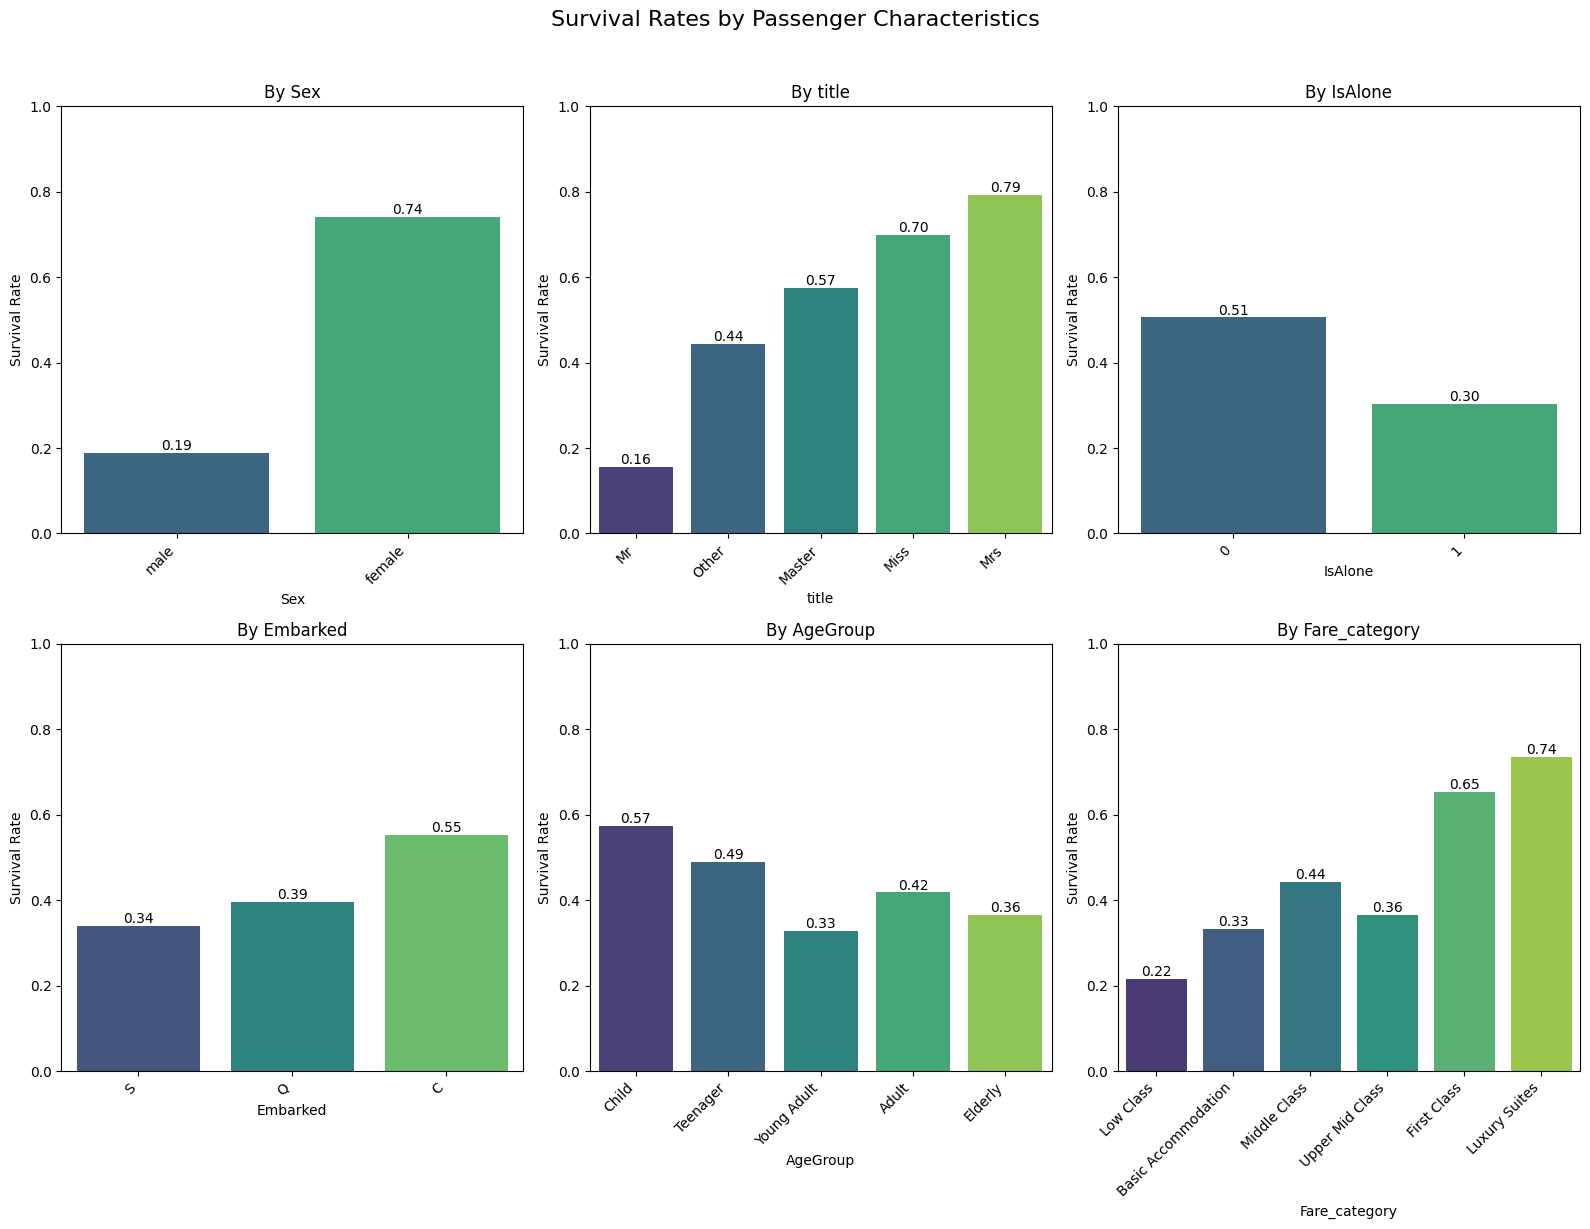

In [41]:
plt.figure(figsize=(16, 12))
plt.suptitle('Survival Rates by Passenger Characteristics', y=1.02, fontsize=16)
# List of categorical features to analyze
features = ['Sex', 'title', 'IsAlone', 'Embarked', 'AgeGroup', 'Fare_category']
# Create subplots
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    # Calculate survival rates
    survival_rate = df.groupby(feature)['Survived'].mean().sort_values()
    # Create bar plot
    ax = sns.barplot(x=survival_rate.index, 
                    y=survival_rate.values,
                    palette='viridis')
    # Customize plot
    plt.title(f'By {feature}')
    plt.ylabel('Survival Rate')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    # Add value labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', 
                   xytext=(0, 5), 
                   textcoords='offset points')
plt.tight_layout()
plt.show()

Extractions: 
1) Females and Children/teenagers are mostly survived from accident. 
2) Many of Cherbourg's embark(C) are not died. (of course can be imbalance data) by the way, Southampton had mostly passenger (about 600 of train_set) but has the lowest rate of survival.
3) That is obvious rich people had live more than poor people.
4) also alone people had fatality mostly.

C:\Users\Alireza\AppData\Local\Temp\ipykernel_12724\2706641619.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


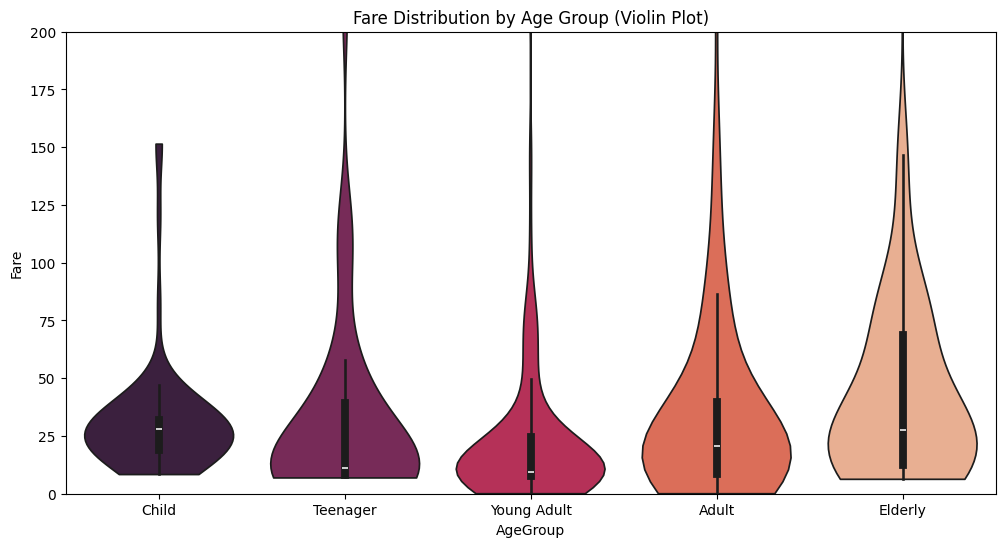

In [42]:
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=df,
    x='AgeGroup',
    y='Fare',
    order=['Child', 'Teenager', 'Young Adult', 'Adult', 'Elderly'],
    palette='rocket',
    cut=0  # To show the full distribution shape
)
plt.title('Fare Distribution by Age Group (Violin Plot)')
plt.ylim(0, 200)  # Limit y-axis to better see patterns
plt.show()

Children/Teenagers are much more paid of Adults!
we had many rich kid in titanic.
lets see how many of them are Alone/Not? 

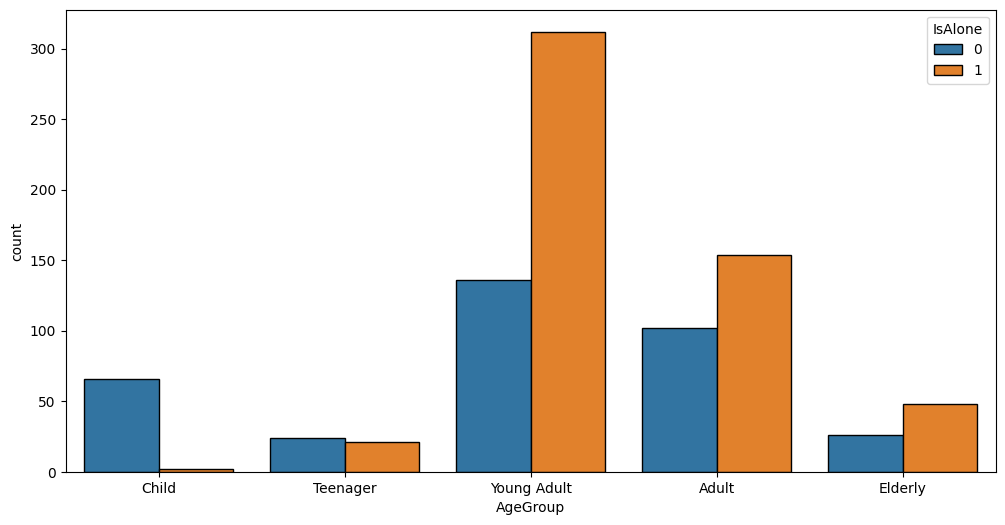

In [44]:
fig = plt.figure(figsize=(12,6))
ax = sns.countplot(
    data=df,
    x='AgeGroup',
    hue='IsAlone',
    palette={0: '#1f77b4', 1: '#ff7f0e'},  # Blue for not alone, orange for alone
    edgecolor='black',
    order=AGE_GROUP_ORDER
)
plt.show()

Thats true. many Adults/YoungAdults people were Alone and died. it is proof that for the first, removed Youngers from ship and after that paid attention to Male/adults.

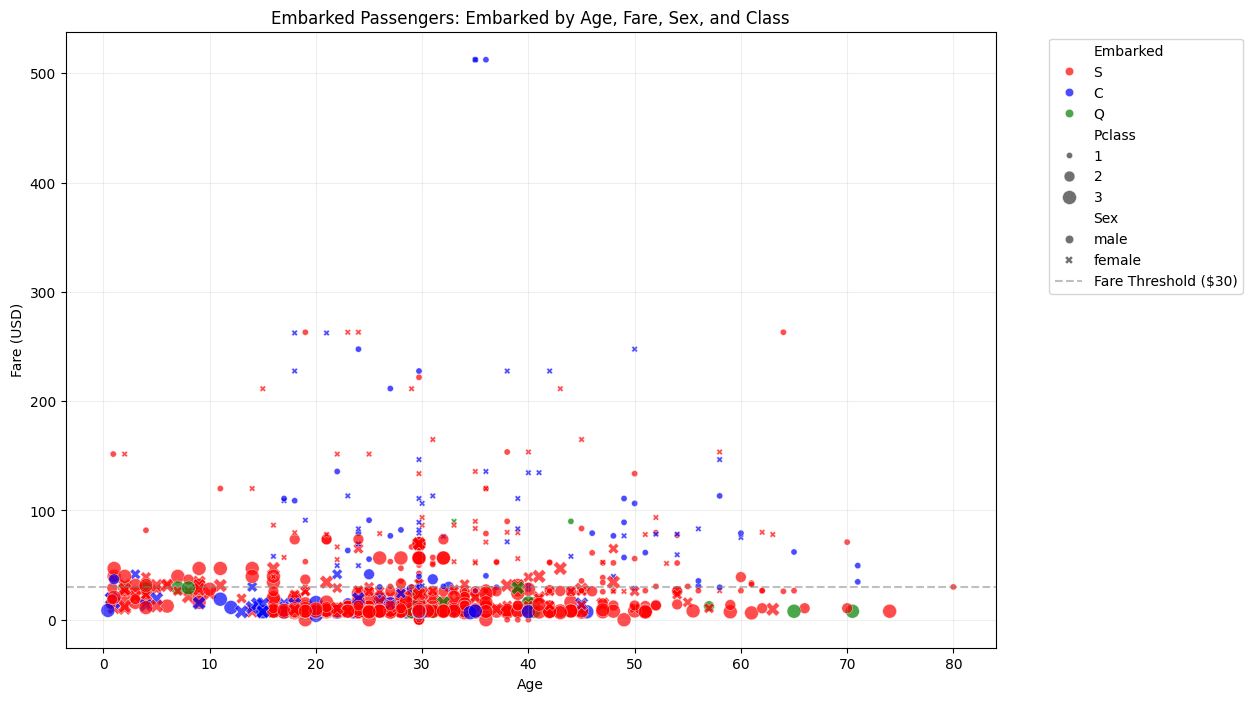

In [45]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='Age',
    y='Fare',
    hue='Embarked',
    style='Sex',
    palette={'S': 'red', 'C': 'blue', 'Q': 'green'},
    size='Pclass',  # Smaller points = higher class (1st class is most important)
    sizes=(20, 100),
    alpha=0.7
)
plt.title('Embarked Passengers: Embarked by Age, Fare, Sex, and Class')
plt.xlabel('Age')
plt.ylabel('Fare (USD)')
plt.axhline(y=30, color='gray', linestyle='--', alpha=0.5, label='Fare Threshold ($30)')  # Reference line for fare threshold
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.2)
plt.show()

That is. 

Many Southampton passengers were Male and low paid fare for this reason they were not alive. in the other hand, Cherbourg had many rich kid so they are survived. 

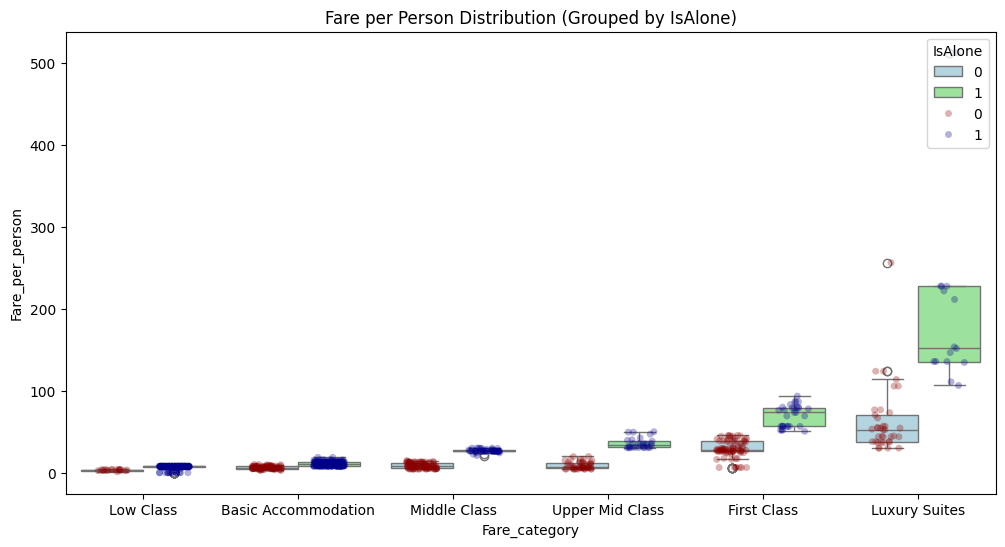

In [63]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Fare_category', 
    y='Fare_per_person', 
    hue='IsAlone',  # Differentiate by IsAlone
    data=df, 
    palette={0: "lightblue", 1: "lightgreen"}
)
sns.stripplot(
    x='Fare_category', 
    y='Fare_per_person', 
    hue='IsAlone',
    data=df, 
    palette={0: "darkred", 1: "darkblue"},
    alpha=0.3, 
    jitter=0.2,
    dodge=True)
plt.title('Fare per Person Distribution (Grouped by IsAlone)')
plt.legend(title='IsAlone', loc='upper right')
plt.show()

Luxury people were alone mostly for this reason it can be had high Fare_per_person. at the all, passengers were not alone in the most of the time.
the first class category caught my attention, paid much more per_person greater than upper mid class passengers even not alone luxury suits people.

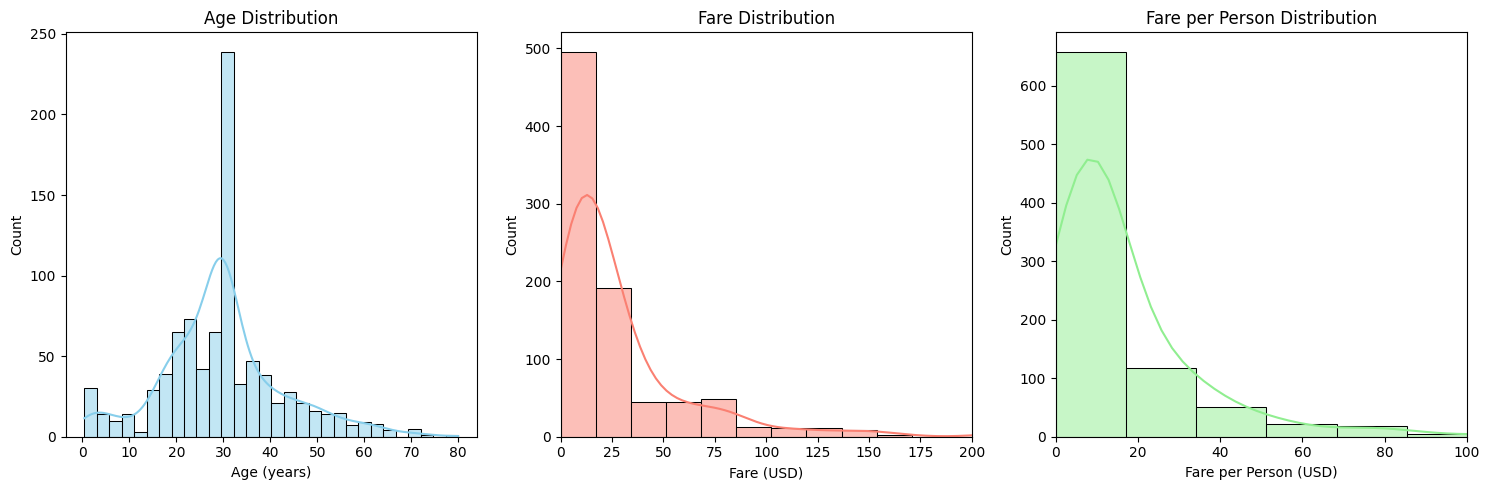

In [225]:
plt.figure(figsize=(15, 5))

# Age Distribution
plt.subplot(1, 3, 1)
sns.histplot(data=df, x='Age', kde=True, color='skyblue', bins=30)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Count')

# Fare Distribution
plt.subplot(1, 3, 2)
sns.histplot(data=df, x='Fare', kde=True, color='salmon', bins=30)
plt.title('Fare Distribution')
plt.xlabel('Fare (USD)')
plt.xlim(0, 200)  # Limit to exclude extreme outliers

# Fare per Person Distribution
plt.subplot(1, 3, 3)
sns.histplot(data=df, x='Fare_per_person', kde=True, color='lightgreen', bins=30)
plt.title('Fare per Person Distribution')
plt.xlabel('Fare per Person (USD)')
plt.xlim(0, 100)  # Common range for better visualization

plt.tight_layout()
plt.show()

We have to convert to Square/Log Fare_per_person/Fare features because they are skewed and also after that StandardScaler() because figures like to normal.
but Age can scale to without log/square change.

In [226]:
ss = StandardScaler()
rs = RobustScaler() # good deal with outliers

df['Age_scaled'] = rs.fit_transform(df[['Age']])
# step1: set log
df['log_fare_per_person'] = df['Fare_per_person'].apply(lambda fare_per_person: np.log1p(fare_per_person + 1e-6))
df['log_fare'] = df['Fare'].apply(lambda fare: np.log1p(fare + 1e-6))
# step2: scale
df['log_fare_per_person_scaled'] = ss.fit_transform(df[['log_fare_per_person']])
df['log_fare_scaled'] = ss.fit_transform(df[['log_fare']])
df[['Age_scaled','log_fare_per_person_scaled', "log_fare_scaled"]].head(2)

,Age_scaled,log_fare_per_person_scaled,log_fare_scaled
0,-0.592240,-1.205713,-0.879741
1,0.638529,1.208790,1.361220


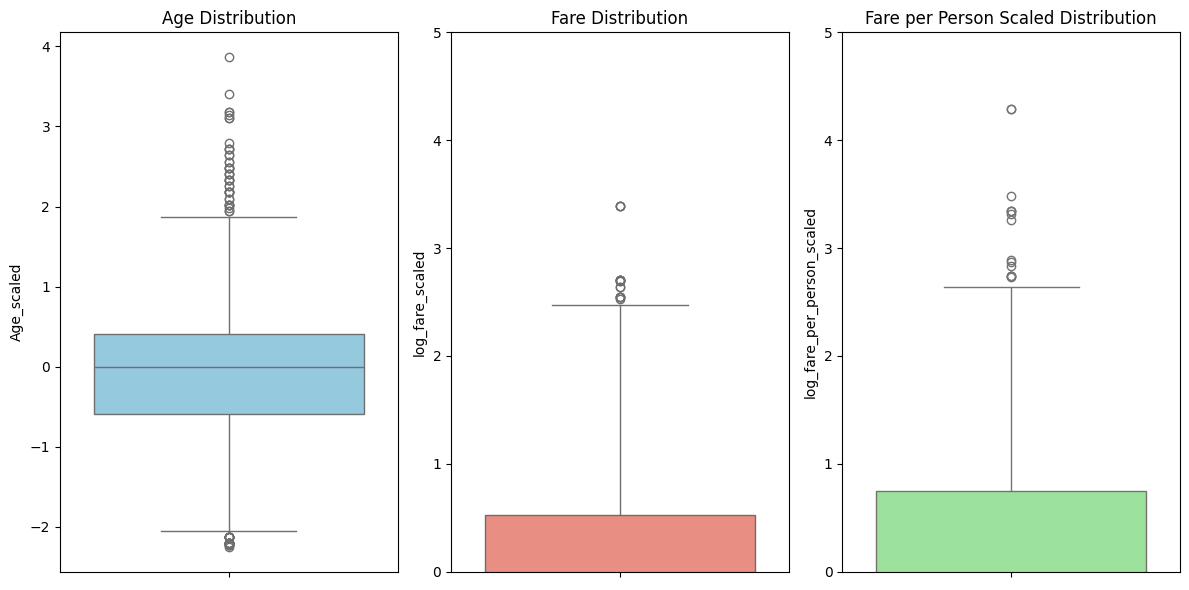

In [227]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(y=df['Age_scaled'], color='skyblue')
plt.title('Age Distribution')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['log_fare_scaled'], color='salmon')
plt.title('Fare Distribution')
plt.ylim(0, 5)

plt.subplot(1, 3, 3)
sns.boxplot(y=df['log_fare_per_person_scaled'], color='lightgreen')
plt.title('Fare per Person Scaled Distribution')
plt.ylim(0, 5)

plt.tight_layout()
plt.show()

that is better to set Clip() for set max/min capacity to stay safe from outliers.

In [228]:
# Cap Age_scaled at 2 (replace values > 2 with 2) and minimum age at -1.6
df['Age_scaled'] = np.clip(df['Age_scaled'], a_min=-1.6, a_max=2)
df['log_fare_scaled'] = np.clip(df['log_fare_scaled'], a_min=None,a_max=2.5)
df['log_fare_per_person_scaled'] = np.clip(df['log_fare_per_person_scaled'], a_min=None,a_max=2.5)

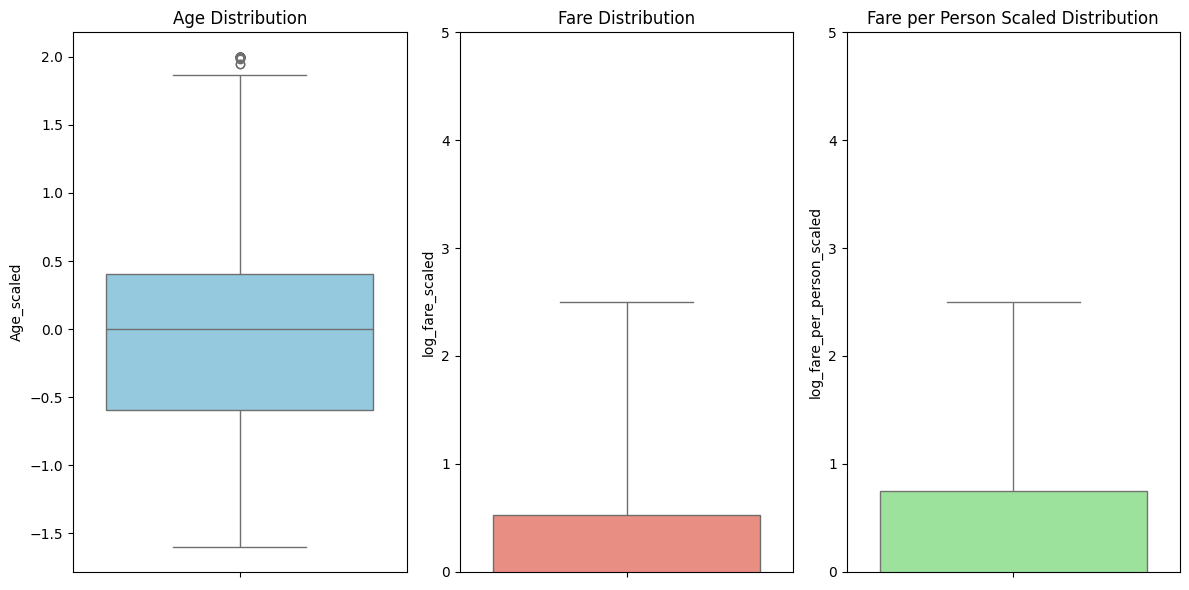

In [229]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(y=df['Age_scaled'], color='skyblue')
plt.title('Age Distribution')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['log_fare_scaled'], color='salmon')
plt.title('Fare Distribution')
plt.ylim(0, 5)

plt.subplot(1, 3, 3)
sns.boxplot(y=df['log_fare_per_person_scaled'], color='lightgreen')
plt.title('Fare per Person Scaled Distribution')
plt.ylim(0, 5)

plt.tight_layout()
plt.show()

it is going better.
now, we can drop Age, Fare, Fare_per_person from dataframe

In [232]:
df.drop(['Age','Fare','Fare_per_person','log_fare_per_person','log_fare'],inplace=True,axis=1)
df.columns

Index(['Pclass', 'Sex', 'Embarked', 'title', 'family_size', 'IsAlone',
       'AgeGroup', 'Fare_category', 'Survived', 'Age_scaled',
       'log_fare_per_person_scaled', 'log_fare_scaled'],
      dtype='object')

# Features Importance

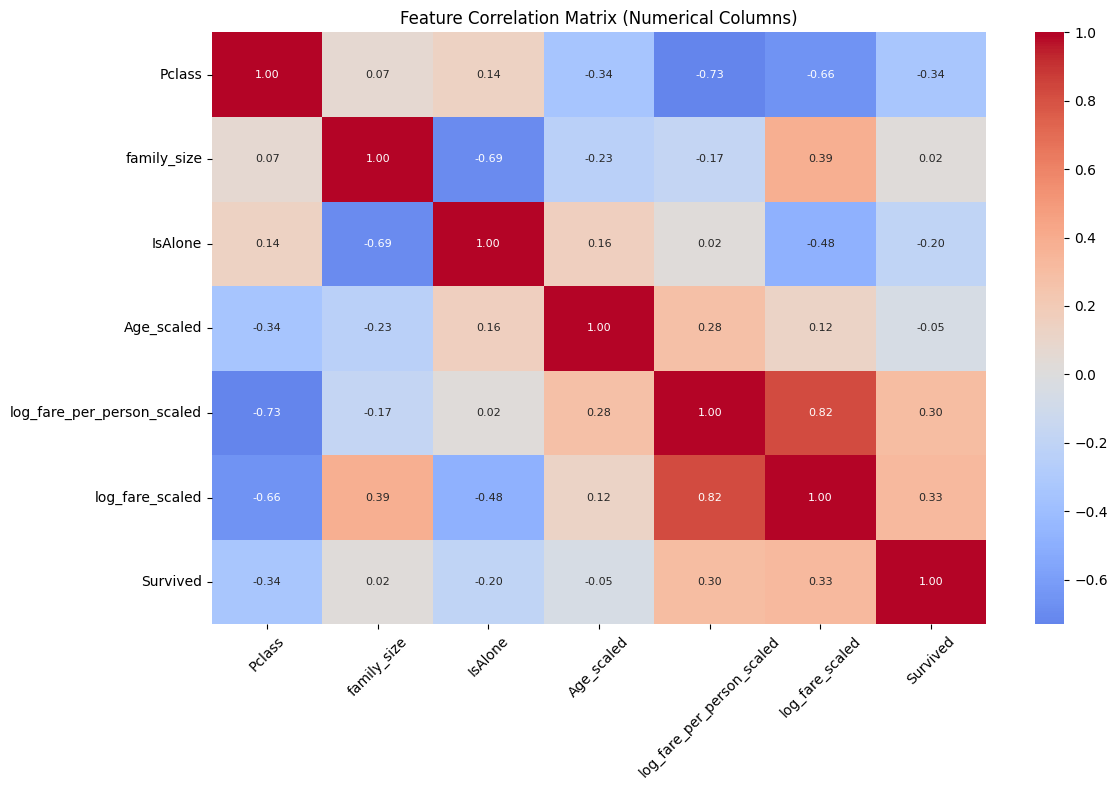

In [239]:
numerical_columns = ['Pclass', 'family_size', 'IsAlone', 'Age_scaled', 'log_fare_per_person_scaled', 'log_fare_scaled', 'Survived']
corr_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',
            center=0,
            annot_kws={"size": 8})
plt.title("Feature Correlation Matrix (Numerical Columns)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

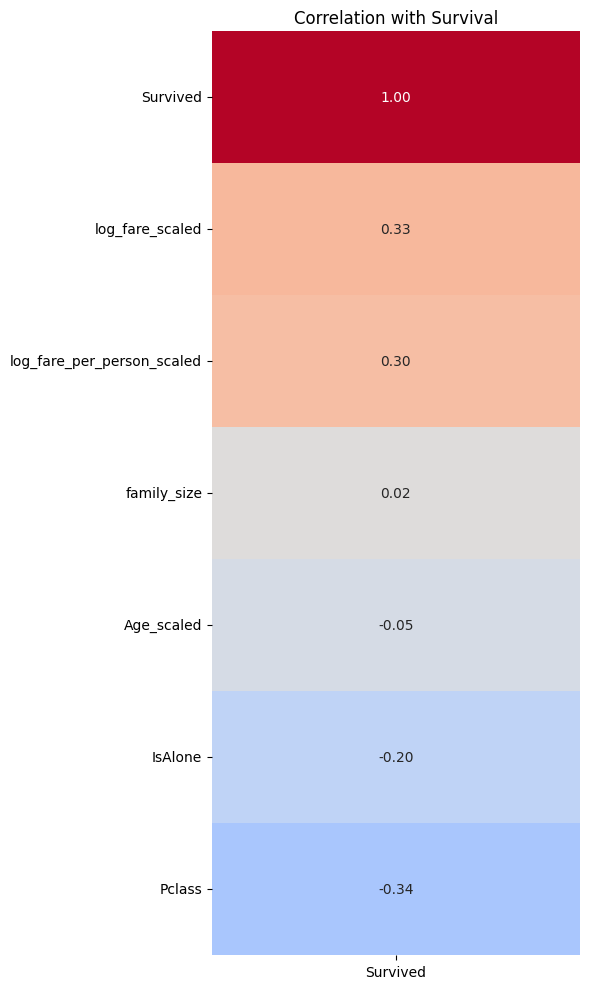

In [237]:
target_corr = corr_matrix[['Survived']].sort_values(by='Survived', ascending=False)
plt.figure(figsize=(6, 10))
sns.heatmap(target_corr, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f",
            center=0,
            cbar=False)
plt.title("Correlation with Survival")
plt.tight_layout()
plt.show()

we can find Fare/Fare_per_person's features have highest correlation with Survived and Pclass/IsAlone have opposite correlation.
also family_size and Age are neutral features.

we are going to check Chi-square test for categorical features....

In [241]:
categorical_columns = ['Sex', 'Embarked', 'title', 'AgeGroup', 'Fare_category']
def chi2_test(df, feature, target='Survived'):
    contingency_table = pd.crosstab(df[feature], df[target])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Test all categorical features
chi2_results = {feature: chi2_test(df, feature) for feature in df[cat_features]}

# Create results DataFrame
chi2_df = pd.DataFrame(chi2_results, index=['Chi2', 'p-value']).T
chi2_df['Significant'] = chi2_df['p-value'] < 0.05
print(chi2_df.sort_values('Chi2', ascending=False))

                     Chi2       p-value  Significant
title          283.311509  4.305036e-60         True
Sex            260.717020  1.197357e-58         True
Fare_category   94.984200  6.017028e-19         True
Embarked        26.129539  2.118570e-06         True
AgeGroup        19.698648  5.726583e-04         True


Chi-Square categorical test shows that Sex/Mr/Miss have most corr with label.
Age is not good for both feature sides, so it shows can be remove from data.

In [244]:
def anova_test(df, feature, target='Survived'):
    groups = df.groupby(target)[feature].apply(list)
    return f_oneway(*groups)

# Test all numerical features
anova_results = {feature: anova_test(df, feature) for feature in numerical_columns if feature != 'Survived'}

anova_df = pd.DataFrame(anova_results, index=['F-statistic', 'p-value']).T
anova_df['Significant'] = anova_df['p-value'] < 0.05
print(anova_df.sort_values('F-statistic', ascending=False))

                            F-statistic       p-value  Significant
Pclass                       115.031272  2.537047e-25         True
log_fare_scaled              108.369024  5.021433e-24         True
log_fare_per_person_scaled    87.444825  6.837992e-20         True
IsAlone                       38.353651  9.009490e-10         True
Age_scaled                     2.533634  1.117988e-01        False
family_size                    0.246193  6.198911e-01        False


family_size and age have lowest score also in anova_test

C:\Users\Alireza\AppData\Local\Temp\ipykernel_12724\3526056131.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MI_Score', y='Feature', data=mi_df, palette='viridis')


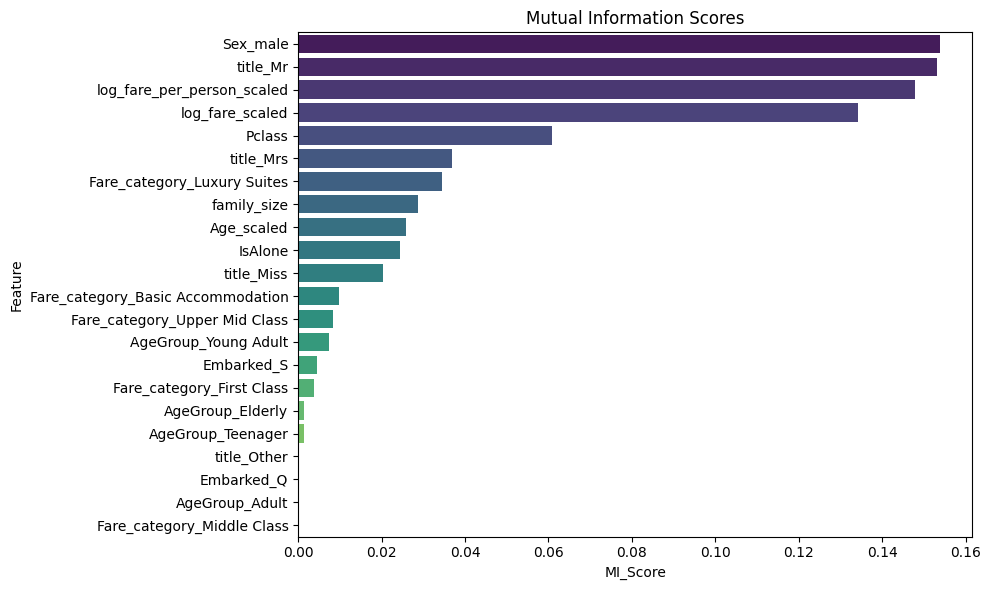

In [249]:
# Encode categorical features
X_encoded = pd.get_dummies(df[categorical_columns + numerical_columns].drop('Survived',axis=1), drop_first=True)
y = df['Survived']
# Calculate mutual information
mi_scores = mutual_info_classif(X_encoded, y)
mi_df = pd.DataFrame({'Feature': X_encoded.columns, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values('MI_Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='MI_Score', y='Feature', data=mi_df, palette='viridis')
plt.title('Mutual Information Scores')
plt.tight_layout()
plt.show()

Based on these analysts, i can be concluded that the strongest correlation with survival (the label) is gender, with a significantly higher number of female passengers surviving, making it a key predictive feature.

Secondly, Fare_category also shows a clear pattern, indicating that wealthier passengers (higher fare categories) had substantially higher survival rates, suggesting socioeconomic status played an important role in survival outcomes.

# Make Features Pipeline

In [295]:
class FeatureEngineering(BaseEstimator,TransformerMixin): 
    FARE_CAT_ORDER: List[str] = ["Low Class", "Basic Accommodation", "Middle Class", "Upper Mid Class", "First Class", "Luxury Suites"]
    AGE_GROUP_ORDER: list[str] = ["Child", "Teenager", "Young Adult", "Adult", "Elderly"]
    def fit(self, X: pd.DataFrame, y: pd.Series | None = None): # noqa: D401
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        
        X["title"] = (
            X["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip())
        X["title"] = X["title"].where(
            X["title"].isin(["Mr", "Miss", "Mrs", "Master"]), "Other"
        )
        
        X["family_size"] = X["SibSp"] + X["Parch"] + 1  # +1 with him/her selves
        X["IsAlone"] = (X["family_size"] == 1).astype(int)
        
        X["Fare_per_person"] = X["Fare"] / X["family_size"].replace(0, np.nan)
        
        fare_bins = [-np.inf, 8, 20, 30, 50, 100, np.inf]
        X["Fare_category"] = pd.cut(X["Fare"], bins=fare_bins, labels=self.FARE_CAT_ORDER)
        
        age_bins = [0, 12, 18, 30, 50, np.inf]
        X["AgeGroup"] = pd.cut(X["Age"],bins=age_bins, labels=self.AGE_GROUP_ORDER, right=False)
        
        return X[["Pclass","Sex","Age","Fare","Embarked","title","family_size", "IsAlone", "AgeGroup", "Fare_category", "Fare_per_person"]]

In [252]:
class FeatureClipper(BaseEstimator, TransformerMixin): 
    def __init__(self, feature_names: list[str], min_values: list[float], max_values: list[float]): 
        self.feature_names = feature_names
        self.min_values = min_values
        self.max_values = max_values
    def fit(self, X, y=None): 
        return self
    def transform(self, X): 
        X = pd.DataFrame(X, columns=self.feature_names)
        for col, min_value, max_value in zip(self.feature_names,self.min_values, self.max_values): 
            X[col] = np.clip(X[col], a_min=min_value, a_max=max_value)
        return X.values
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names)

In [303]:
numeric_features: list[str] = ["Age"]
ordinal_features: list[str] = ["Fare_category", "AgeGroup"]
nominal_features: list[str] = ["Sex","Embarked","title"]
log_features: list[str] = ["Fare", "Fare_per_person"]

numeric_transformer : Pipeline = Pipeline(
    steps=[
        ("imputer", IterativeImputer(random_state=42)),
        ("scaler", RobustScaler()), # good deal with outliers
        ("clipper", FeatureClipper(["Age"], [-1.5], [2.0])),
    ]
)
log_transformer: Pipeline = Pipeline(
    steps=[
        ("imputer", IterativeImputer(random_state=42)),
        ("log", FunctionTransformer(np.log1p, validate=False,feature_names_out='one-to-one')),
        ("scaler", StandardScaler()),
        ("clipper", FeatureClipper(['Fare', 'Fare_per_person'],[None, None],[2.5, 2.5]))
    ]
)
ordinal_transformer: Pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("encoder", OrdinalEncoder(categories=[FeatureEngineering.FARE_CAT_ORDER,FeatureEngineering.AGE_GROUP_ORDER], dtype=np.int32, handle_unknown='use_encoded_value', 
                                  unknown_value=-1))])
nominal_transformer: Pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [304]:
preprocessor: ColumnTransformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("ordinal", ordinal_transformer, ordinal_features),
        ("nominal", nominal_transformer, nominal_features),
        ("log", log_transformer, log_features)
    ]
)
preprocessor

,transformers,"[('numeric', ...), ('ordinal', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,estimator,None
,missing_values,nan
,sample_posterior,False


In [305]:
titanic_features_pipeline: Pipeline = Pipeline(
    steps=[
        ('Features', FeatureEngineering()),
        ("Preprocess", preprocessor)
    ]
)
titanic_features_pipeline

,steps,"[('Features', ...), ('Preprocess', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('ordinal', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [306]:
X_train = train_df.drop(columns="Survived", axis=1)
y_train = train_df["Survived"]
X_test = test_df[X_train.columns]
titanic_features_pipeline.fit(X_train, y_train)  # Make sure X_train contains all needed columns
# Extract feature names
feature_names = titanic_features_pipeline.named_steps['Preprocess'].get_feature_names_out()
X_train_processed = titanic_features_pipeline.transform(X_train)
X_test_processed = titanic_features_pipeline.transform(X_test)

c:\Users\Alireza\Python 3.11.9\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Alireza\Python 3.11.9\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Alireza\Python 3.11.9\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Alireza\Python 3.11.9\Lib\site-packages\sklearn\pipeline.py:61: 

# Models Evaluation

In [312]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, bootstrap=True),
    param_grid=param_grid,
    scoring='accuracy',  # Or use 'f1', 'roc_auc', etc.
    cv=5,                # 5-fold cross-validation
    n_jobs=-1,           # Use all CPU cores
    verbose=2            # Display progress
)

grid_search.fit(X_train_processed,y_train)

# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Best Score: 0.8350009415604795


In [310]:
param_dist = {
    'n_estimators': [150, 250, 350, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': np.logspace(-3, -1, 10),  # More granular learning rates
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10] 
}

xgb = XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='logloss',n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    scoring='accuracy',  # or 'f1', 'roc_auc', etc.
    cv=5,               
    n_jobs=-1,          
    verbose=2, 
    random_state=42           
)
random_search.fit(X_train_processed,y_train)

best_xgb = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best Parameters: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': np.float64(0.03593813663804626), 'gamma': 0.2, 'colsample_bytree': 0.8}
Best Score: 0.8395204318624065


In [314]:
best_forest = grid_search.best_estimator_
print(best_xgb,'\n',best_forest)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.03593813663804626), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=-1,
              num_parallel_tree=None, ...) 
 RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=150, random_state=42)


### Calibration & Calibration Curve

In [ ]:
# from sklearn.calibration import CalibratedClassifierCV

# calibrated_xgb = CalibratedClassifierCV(base_estimator=best_xgb,method='sigmoid',cv=5)
# calibrated_xgb.fit(X_train_processed,y_train)

# probs_raw = best_xgb.predict_proba(X_)[:,1]
# probs_cal = calibrated_xgb.predict_proba(X_val)[:,1]

# plt.figure(figsize=(8, 6))

# for p, label in zip([probs_raw, probs_cal], ["Before", "After"]):
#     prob_true, prob_pred = calibration_curve(y_val, p, n_bins=10)
#     plt.plot(prob_pred, prob_true, marker='o', label=label)

# plt.plot([0, 1], [0, 1], "--", label="Perfect Calibration")
# plt.xlabel("Predicted probability")
# plt.ylabel("Actual frequency")
# plt.title("Calibration Curve (XGBoost)")
# plt.legend()
# plt.grid(True)
# plt.show()

### SHAP Plots For XGB

In [ ]:
# import shap

# explainer = shap.Explainer(best_xgb)
# shap_val = explainer(X_train_processed)
# shap.summary_plot(shap_val, X_train_processed, plot_type="bar")
# shap.summary_plot(shap_val, X_train_processed)
# shap.plots.waterfall(shap_val[0])

In [ ]:
y_train_predict_forest = cross_val_predict(best_forest,X_train_processed,y_train,cv=3)
y_train_predict_xgb = cross_val_predict(best_xgb,X_train_processed,y_train,cv=3)

cm_forest = confusion_matrix(y_train,y_train_predict_forest)
cm_xgb = confusion_matrix(y_train,y_train_predict_xgb)
print("Confusion Matrix Random Forest:  ",'\n',cm_forest)
print("Confusion Matrix XGBoost:  ",'\n',cm_xgb)

Confusion Matrix Random Forest:   
 [[476  73]
 [ 90 252]]
Confusion Matrix XGBoost:   
 [[490  59]
 [ 97 245]]


Confusion Matrix: 
    first_row: (True Negative --------------------- False Positive)

    
    second_row: (False Negative --------------------- True Positive)

Random Forest has false negative lower than XGBoost. false negative it is important section of this dataset and concept. but XGBoost has accuracy more than rforest.
we will see precision and recall too.

In [317]:
print("forest precision score:  ", precision_score(y_train, y_train_predict_forest))
print("forest recall score:  ", recall_score(y_train, y_train_predict_forest))
print('forest f1 score:  ', f1_score(y_train, y_train_predict_forest))
print("xgboost precision score:  ", precision_score(y_train, y_train_predict_xgb))
print("xgboost recall score:  ", recall_score(y_train, y_train_predict_xgb))
print('xgboost f1 score:  ', f1_score(y_train, y_train_predict_xgb))

forest precision score:   0.7753846153846153
forest recall score:   0.7368421052631579
forest f1 score:   0.7556221889055472
xgboost precision score:   0.805921052631579
xgboost recall score:   0.716374269005848
xgboost f1 score:   0.7585139318885449


in this case, we need to high recall score and precision score is not priority. 
if we predict wrong alive passenger is not very bad but if we say wrong dead passenger, its terrible.

In [318]:
y_scores_forest = cross_val_predict(best_forest,X_train_processed,y_train,cv=3,method='predict_proba')[:,1] # just slice the positive class column
y_scores_xgb = cross_val_predict(best_xgb,X_train_processed,y_train,cv=3,method='predict_proba')[:,1]

In [319]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train, y_scores_forest)
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_train, y_scores_xgb)

find the best threshold for recall score: 

In [321]:
best_recall_idx_forest = np.abs(recalls_forest - 0.9).argmin()
# Ensure the recall at this index is <= 0.9
if recalls_forest[best_recall_idx_forest] > 0.9:
    best_recall_idx_forest -= 1

forest_threshold = thresholds_forest[best_recall_idx_forest]
forest_threshold

np.float64(0.15849940449480535)

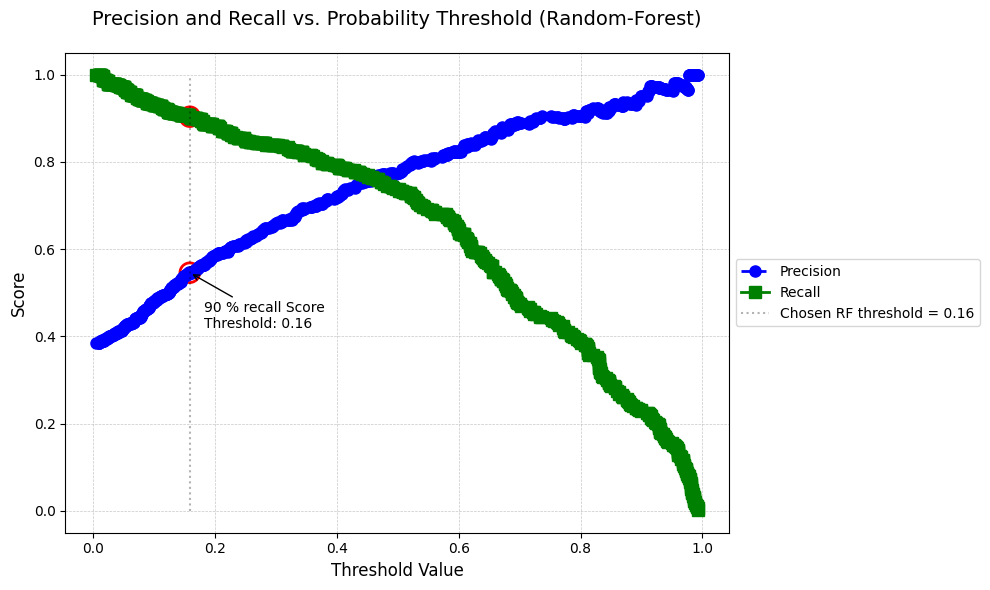

In [322]:
plt.figure(figsize=(10, 6))

# Curves
plt.plot(thresholds_forest, precisions_forest[:-1], "b--", label="Precision", linewidth=2, marker='o', markersize=8)
plt.plot(thresholds_forest, recalls_forest[:-1],   "g-" , label="Recall",    linewidth=2, marker='s', markersize=8)

# Vertical line at the chosen Random‑Forest threshold
plt.vlines(forest_threshold, 0, 1.0, colors="k", linestyles="dotted",
           alpha=0.3, label=f"Chosen RF threshold = {forest_threshold:.2f}")

# Aesthetics
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel("Threshold Value", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Precision and Recall vs. Probability Threshold (Random-Forest)", fontsize=14, pad=20)
plt.xlim(thresholds_forest.min() - 0.05, thresholds_forest.max() + 0.05)
plt.ylim(-0.05, 1.05)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

# Highlight the max‑recall score
plt.scatter(thresholds_forest[best_recall_idx_forest], precisions_forest[best_recall_idx_forest],
            s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.scatter(thresholds_forest[best_recall_idx_forest], recalls_forest[best_recall_idx_forest],
            s=200, facecolors='none', edgecolors='r', linewidths=2)

plt.annotate(f'90 % recall Score \nThreshold: {forest_threshold:.2f}',
             xy=(thresholds_forest[best_recall_idx_forest], precisions_forest[best_recall_idx_forest]),
             xytext=(10, -40), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.tight_layout()
plt.show()

threshold = 0.16 is the best point for 90 % recall score random forest.

In [323]:
y_train_pred_90_forest = (y_scores_forest >= forest_threshold)

print("precision score:  ", precision_score(y_train, y_train_pred_90_forest))
print("recall score:  ", recall_score(y_train, y_train_pred_90_forest))

precision score:   0.5459363957597173
recall score:   0.9035087719298246


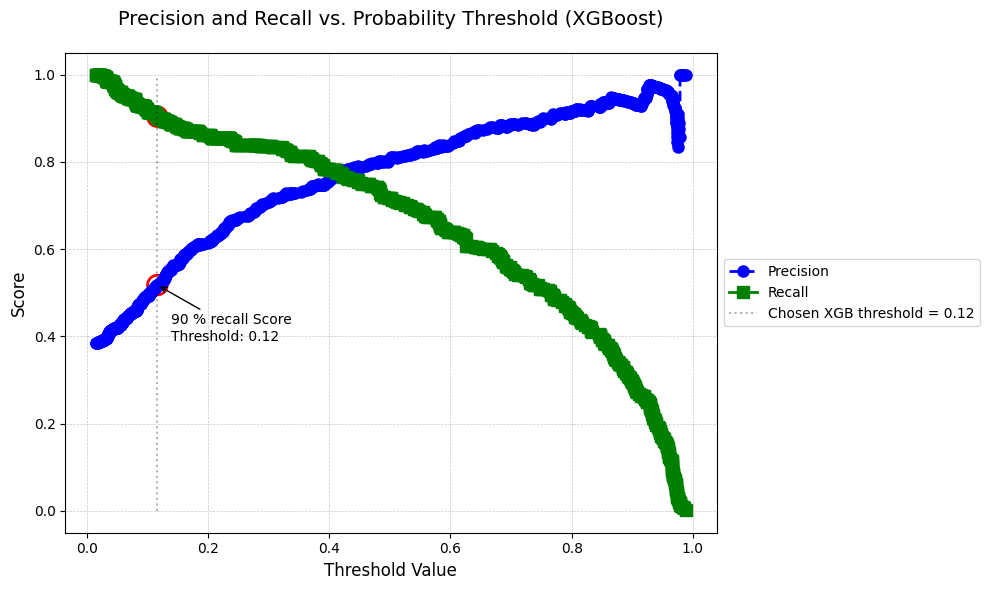

In [324]:
best_recall_idx_xgb = np.abs(recalls_xgb - 0.9).argmin()
# Ensure the recall at this index is <= 0.9
if recalls_xgb[best_recall_idx_xgb] > 0.9:
    best_recall_idx_xgb -= 1

xgb_threshold = thresholds_xgb[best_recall_idx_xgb]

plt.figure(figsize=(10, 6))
# Curves
plt.plot(thresholds_xgb, precisions_xgb[:-1], "b--", label="Precision", linewidth=2, marker='o', markersize=8)
plt.plot(thresholds_xgb, recalls_xgb[:-1],   "g-" , label="Recall",    linewidth=2, marker='s', markersize=8)
plt.vlines(xgb_threshold, 0, 1.0, colors="k", linestyles="dotted",
           alpha=0.3, label=f"Chosen XGB threshold = {xgb_threshold:.2f}")

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel("Threshold Value", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Precision and Recall vs. Probability Threshold (XGBoost)", fontsize=14, pad=20)
plt.xlim(thresholds_xgb.min() - 0.05, thresholds_xgb.max() + 0.05)
plt.ylim(-0.05, 1.05)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
# Highlight the max‑recall score
plt.scatter(thresholds_xgb[best_recall_idx_xgb], precisions_xgb[best_recall_idx_xgb],
            s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.scatter(thresholds_xgb[best_recall_idx_xgb], recalls_xgb[best_recall_idx_xgb],
            s=200, facecolors='none', edgecolors='r', linewidths=2)

plt.annotate(f'90 % recall Score \nThreshold: {xgb_threshold:.2f}',
             xy=(thresholds_xgb[best_recall_idx_xgb], precisions_xgb[best_recall_idx_xgb]),
             xytext=(10, -40), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))
plt.tight_layout()
plt.show()

In [325]:
y_train_pred_90_xgb = (y_scores_xgb >= xgb_threshold)
print("precision score:  ", precision_score(y_train, y_train_pred_90_xgb))
print("recall score:  ", recall_score(y_train, y_train_pred_90_xgb))

precision score:   0.5175879396984925
recall score:   0.9035087719298246


update the precisions,recalls,thresholds for best recall scores: 

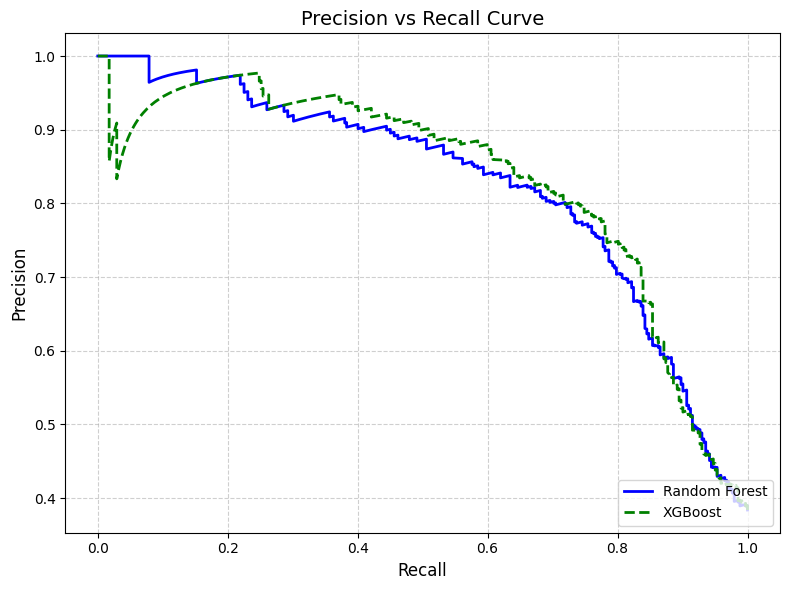

In [326]:
plt.figure(figsize=(8, 6))
# Plot the Precision-Recall curves
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls_xgb, precisions_xgb, "g--", linewidth=2, label="XGBoost")
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision vs Recall Curve", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()

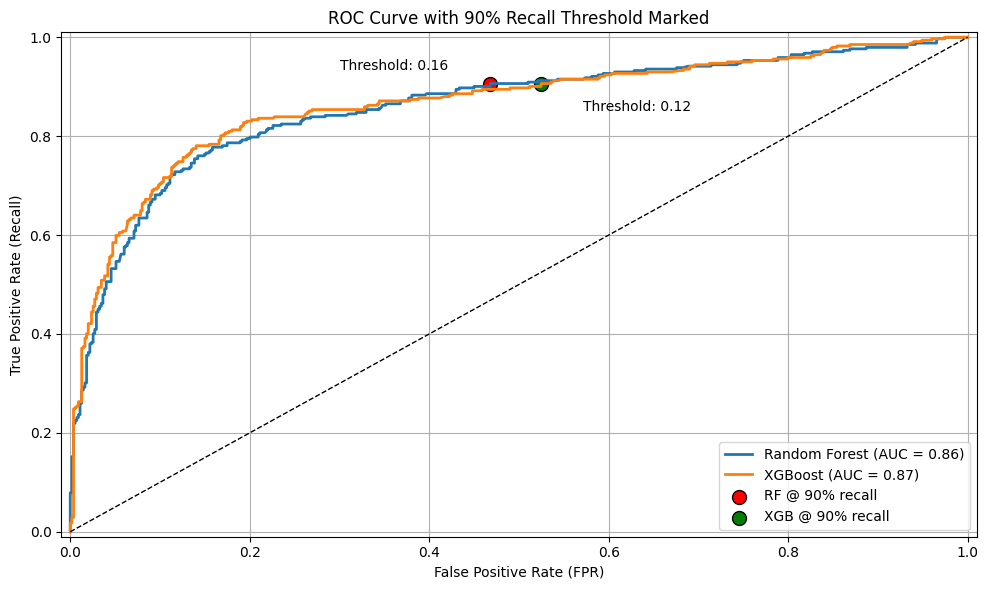

In [ ]:
fpr_rf, tpr_rf, roc_thresholds_rf = roc_curve(y_train,y_scores_forest)
fpr_xgb, tpr_xgb, roc_thresholds_xgb = roc_curve(y_train,y_scores_xgb)

auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

rf_roc_idx = np.where(roc_thresholds_rf <= forest_threshold)[0][0]
xgb_roc_idx = np.where(roc_thresholds_xgb <= xgb_threshold)[0][0]

plt.figure(figsize=(10, 6))

# Plot full ROC curves
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})", linewidth=2)

# Plot markers at 90% recall thresholds
plt.scatter(fpr_rf[rf_roc_idx], tpr_rf[rf_roc_idx],
            color='red', s=100, label="RF @ 90% recall", edgecolors='black')
plt.scatter(fpr_xgb[xgb_roc_idx], tpr_xgb[xgb_roc_idx],
            color='green', s=100, label="XGB @ 90% recall", edgecolors='black')

plt.annotate(f"Threshold: {forest_threshold:.2f}", 
             (fpr_rf[rf_roc_idx], tpr_rf[rf_roc_idx]), 
             textcoords="offset points", xytext=(-30,10), ha='right')

plt.annotate(f"Threshold: {xgb_threshold:.2f}", 
             (fpr_xgb[xgb_roc_idx], tpr_xgb[xgb_roc_idx]), 
             textcoords="offset points", xytext=(30,-20), ha='left')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve with 90% Recall Threshold Marked")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

The thresholds (0.16 for RF, 0.12 for XGB) suggest that XGB requires a higher confidence level for the positive class at 90% recall.

Find the FP rates: 

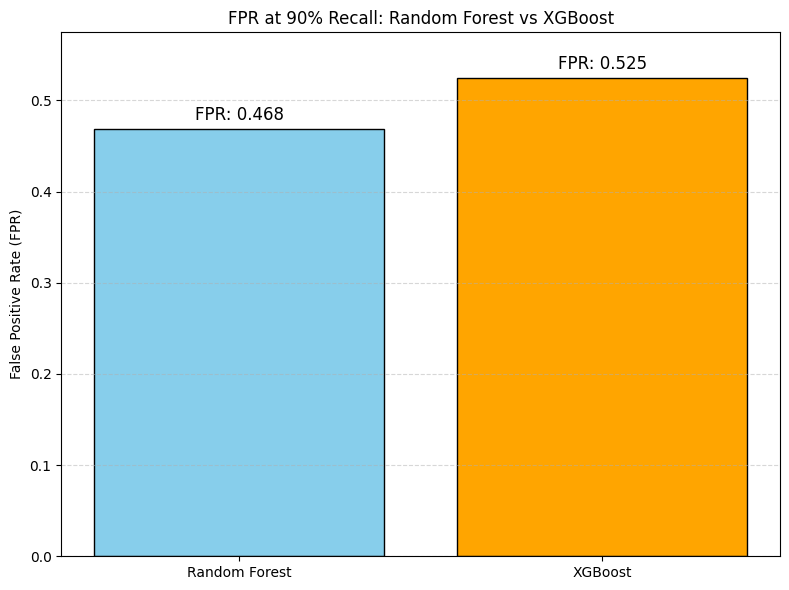

In [328]:
fpr_rf_90 = fpr_rf[rf_roc_idx]
fpr_xgb_90 = fpr_xgb[xgb_roc_idx]

plt.figure(figsize=(8, 6))
plt.bar(["Random Forest", "XGBoost"],[fpr_rf_90, fpr_xgb_90],color=["skyblue", "orange"],edgecolor="black")
# Annotate the bars
plt.text(0, fpr_rf_90 + 0.01, f"FPR: {fpr_rf_90:.3f}", ha='center', fontsize=12)
plt.text(1, fpr_xgb_90 + 0.01, f"FPR: {fpr_xgb_90:.3f}", ha='center', fontsize=12)
plt.ylabel("False Positive Rate (FPR)")
plt.title("FPR at 90% Recall: Random Forest vs XGBoost")
plt.ylim(0, max(fpr_rf_90, fpr_xgb_90) + 0.05)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Both of models are very similar together but i choose Random Forest because remember,  If FPR matters more, pick the model with lower FPR

# Final Pipeline & Model Selection

In [330]:
final_pipeline = Pipeline(
    steps=[
    ("FeatureEngineering", FeatureEngineering()),
    ("Preprocess",preprocessor),
    ("Model",best_forest)
])
final_pipeline

,steps,"[('FeatureEngineering', ...), ('Preprocess', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('ordinal', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
